<a href="https://colab.research.google.com/github/PauloMPPatricio/challenge-desafio-alura-store/blob/main/AluraStoreBr_rv6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importação dos dados



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.graph_objects as go
from IPython.display import display, HTML

# URLs dos arquivos no GitHub
url1 = "https://raw.githubusercontent.com/PauloMPPatricio/challenge-desafio-alura-store/refs/heads/main/base-de-dados-challenge-1/loja_1.csv"
url2 = "https://raw.githubusercontent.com/PauloMPPatricio/challenge-desafio-alura-store/refs/heads/main/base-de-dados-challenge-1/loja_2.csv"
url3 = "https://raw.githubusercontent.com/PauloMPPatricio/challenge-desafio-alura-store/refs/heads/main/base-de-dados-challenge-1/loja_3.csv"
url4 = "https://raw.githubusercontent.com/PauloMPPatricio/challenge-desafio-alura-store/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"

# Paletas de Cores

# Paleta para gráficos Matplotlib (ex: gráfico de barras total por loja)
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

# Paleta para gráficos Plotly (ex: gráficos interativos por loja)
cores_lojas = {
    'Loja 1': '#636EFA',
    'Loja 2': '#EF553B',
    'Loja 3': '#00CC96',
    'Loja 4': '#AB63FA'
}


# Leitura dos arquivos CSV e nomenclatura das lojas
loja1 = pd.read_csv(url1).assign(Loja="Loja 1")
loja2 = pd.read_csv(url2).assign(Loja="Loja 2")
loja3 = pd.read_csv(url3).assign(Loja="Loja 3")
loja4 = pd.read_csv(url4).assign(Loja="Loja 4")

# Exibe as primeiras 5 linhas do DataFrame loja1
display(loja1.head())

,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Loja
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,Loja 1
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,Loja 1
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,15/03/2021,João Souza,DF,1,cartao_credito,1,-15.83,-47.86,Loja 1
3,Micro-ondas,eletrodomesticos,1009.99,54.667344,03/05/2022,João Souza,RS,4,boleto,1,-30.17,-53.50,Loja 1
4,Cadeira de escritório,moveis,446.99,26.964689,07/11/2020,Larissa Alves,MG,5,boleto,1,-18.10,-44.38,Loja 1


#1. Análise do faturamento


In [2]:
# @title
# Convertendo a coluna "Data da Compra" para datetime e extraindo o ano
for loja in [loja1, loja2, loja3, loja4]:
    loja["Data da Compra"] = pd.to_datetime(loja["Data da Compra"], dayfirst=True)
    loja["Ano"] = loja["Data da Compra"].dt.year

# Função para calcular o faturamento anual de uma loja
def calcular_faturamento_anual(loja_df, nome_loja):
    return (
        loja_df.groupby("Ano")["Preço"]
        .sum()
        .reset_index(name="Faturamento")
        .assign(Loja=nome_loja)
    )

# Aplicando a função em cada loja
faturamento_ano_loja1 = calcular_faturamento_anual(loja1, "Loja 1")
faturamento_ano_loja2 = calcular_faturamento_anual(loja2, "Loja 2")
faturamento_ano_loja3 = calcular_faturamento_anual(loja3, "Loja 3")
faturamento_ano_loja4 = calcular_faturamento_anual(loja4, "Loja 4")

# Concatenando os DataFrames
df_faturamento_anual = pd.concat([
    faturamento_ano_loja1,
    faturamento_ano_loja2,
    faturamento_ano_loja3,
    faturamento_ano_loja4
], ignore_index=True)

# Formatando como moeda brasileira
df_faturamento_anual["Faturamento Formatado"] = df_faturamento_anual["Faturamento"].apply(
    lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.')
)

# Reestruturando o DataFrame: lojas como linhas e anos como colunas
df_pivot = df_faturamento_anual.pivot(index="Loja", columns="Ano", values="Faturamento Formatado")

# Ordenando colunas por ano (ordem crescente)
df_pivot = df_pivot[sorted(df_pivot.columns)]

# Preenchendo possíveis valores ausentes com "R$ 0,00"
df_pivot = df_pivot.fillna("R$ 0,00")

# Exibindo resultado final
df_pivot


Ano,2020,2021,2022,2023
Loja,,,,
Loja 1,"R$ 491.911,51","R$ 482.829,91","R$ 422.086,24","R$ 137.681,46"
Loja 2,"R$ 427.288,25","R$ 468.288,89","R$ 477.635,56","R$ 115.246,36"
Loja 3,"R$ 428.943,09","R$ 483.938,91","R$ 467.250,70","R$ 83.892,33"
Loja 4,"R$ 441.129,52","R$ 463.763,27","R$ 402.961,23","R$ 76.643,56"


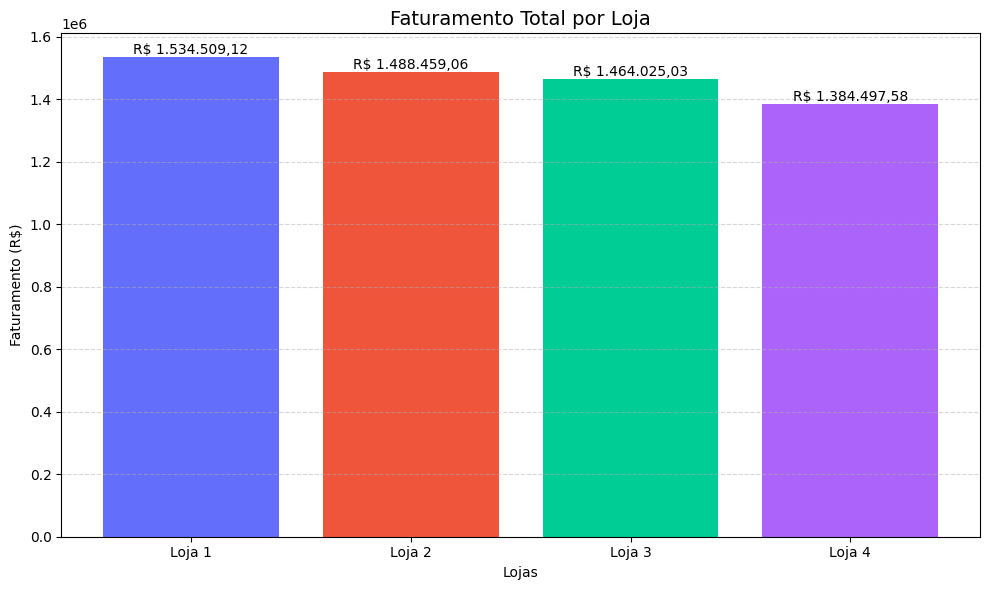

In [3]:
# Calculo dinâmico do faturamento (para gerar o gráfico)
faturamentos_valores = df_faturamento_anual.groupby("Loja")["Faturamento"].sum()

# Criando DataFrame
df_faturamento_plot = faturamentos_valores.reset_index()
df_faturamento_plot.columns = ["Loja", "Faturamento"]

# Plotando o gráfico de barras com paleta de cores harmoniosa
plt.figure(figsize=(10, 6))

bars = plt.bar(df_faturamento_plot["Loja"], df_faturamento_plot["Faturamento"], color=colors)

# Adicionando rótulos nos topos das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'R$ {yval:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'),
             ha='center', va='bottom', fontsize=10)

# Título e rótulos
plt.title("Faturamento Total por Loja", fontsize=14)
plt.xlabel("Lojas")
plt.ylabel("Faturamento (R$)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [4]:
# Recriar base completa
anos = [2020, 2021, 2022, 2023]
lojas = df_faturamento_anual["Loja"].unique()

# Garantir todos os pares Loja x Ano
base = pd.MultiIndex.from_product([lojas, anos], names=["Loja", "Ano"]).to_frame(index=False)
df_merge = pd.merge(base, df_faturamento_anual, how="left", on=["Loja", "Ano"]).fillna(0)

# Formatar o faturamento
df_merge["Faturamento Formatado"] = df_merge["Faturamento"].apply(
    lambda x: f'R$ {x:,.2f}'.replace(",", "v").replace(".", ",").replace("v", ".")
)

# Gerar um X artificial para posicionar as barras agrupadas
x_labels = []
tick_vals = []
tick_text = []
pos = 0

for loja in lojas:
    for ano in anos:
        x_labels.append(pos)
        pos += 1
    tick_vals.append((pos - 4) + 1.5)  # Centraliza o nome da loja
    tick_text.append(loja)
    pos += 0.5  # Espaço entre os blocos

# Substitui a posição por 'x' artificial
df_merge["x"] = x_labels

# Criar a figura
fig = go.Figure()

for i, loja in enumerate(lojas):
    df_loja = df_merge[df_merge["Loja"] == loja]
    fig.add_trace(go.Bar(
        x=df_loja["x"],
        y=df_loja["Faturamento"],
        name=loja,
        marker_color=colors[i % len(colors)],
        text=df_loja["Ano"],
        textposition="outside",
        customdata=np.stack((df_loja["Loja"], df_loja["Ano"], df_loja["Faturamento Formatado"]), axis=-1),
        hovertemplate="<br>".join([
            "Faturamento: %{customdata[2]}"
        ])
    ))

# Layout com nomes únicos por grupo no eixo X
fig.update_layout(
    barmode="group",
    xaxis=dict(
        tickmode="array",
        tickvals=tick_vals,
        ticktext=tick_text,
        title="Loja",
    ),
    yaxis=dict(
        title="Faturamento (R$)"
    ),
    hoverlabel=dict(font_color="white"),
    showlegend=False,
    title="Faturamento Anual por Loja (Gráfico Interativo - Passe o Cursor sobre as Barras)"
)

fig.show()

# 2. Vendas por Categoria


In [5]:
# Juntando tudo em um único DataFrame
todas_lojas = pd.concat([loja1, loja2, loja3, loja4])

# Agrupando por Categoria do Produto e Loja
vendas_categoria_loja = todas_lojas.groupby(["Categoria do Produto", "Loja"])["Preço"].sum().reset_index()

# Pivotando para reorganizar a tabela
tabela_final = vendas_categoria_loja.pivot(index="Categoria do Produto", columns="Loja", values="Preço")

# Preenchendo valores faltantes com zero
tabela_final.fillna(0, inplace=True)

# Renomeando as colunas
tabela_final.columns = [f"Vendas {col}" for col in tabela_final.columns]

# Formatando os valores como moeda brasileira usando map() para evitar warnings
for coluna in tabela_final.columns:
    tabela_final[coluna] = tabela_final[coluna].map(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

# Renomeando o índice para exibir como cabeçalho
tabela_formatada = tabela_final.reset_index()

# Exibindo a tabela formatada
tabela_formatada

,Categoria do Produto,Vendas Loja 1,Vendas Loja 2,Vendas Loja 3,Vendas Loja 4
0,brinquedos,"R$ 23.993,78","R$ 21.262,21","R$ 25.869,20","R$ 27.015,67"
1,eletrodomesticos,"R$ 484.913,36","R$ 464.758,13","R$ 438.984,89","R$ 377.680,65"
2,eletronicos,"R$ 572.659,23","R$ 547.773,71","R$ 547.699,92","R$ 545.966,86"
3,esporte e lazer,"R$ 52.387,55","R$ 46.326,09","R$ 47.456,10","R$ 44.465,65"
4,instrumentos musicais,"R$ 121.731,69","R$ 139.987,03","R$ 103.174,45","R$ 100.136,50"
5,livros,"R$ 11.713,92","R$ 13.454,35","R$ 12.664,70","R$ 12.427,77"
6,moveis,"R$ 250.178,11","R$ 235.234,68","R$ 268.095,56","R$ 256.705,65"
7,utilidades domesticas,"R$ 16.931,48","R$ 19.662,86","R$ 20.080,21","R$ 20.098,83"


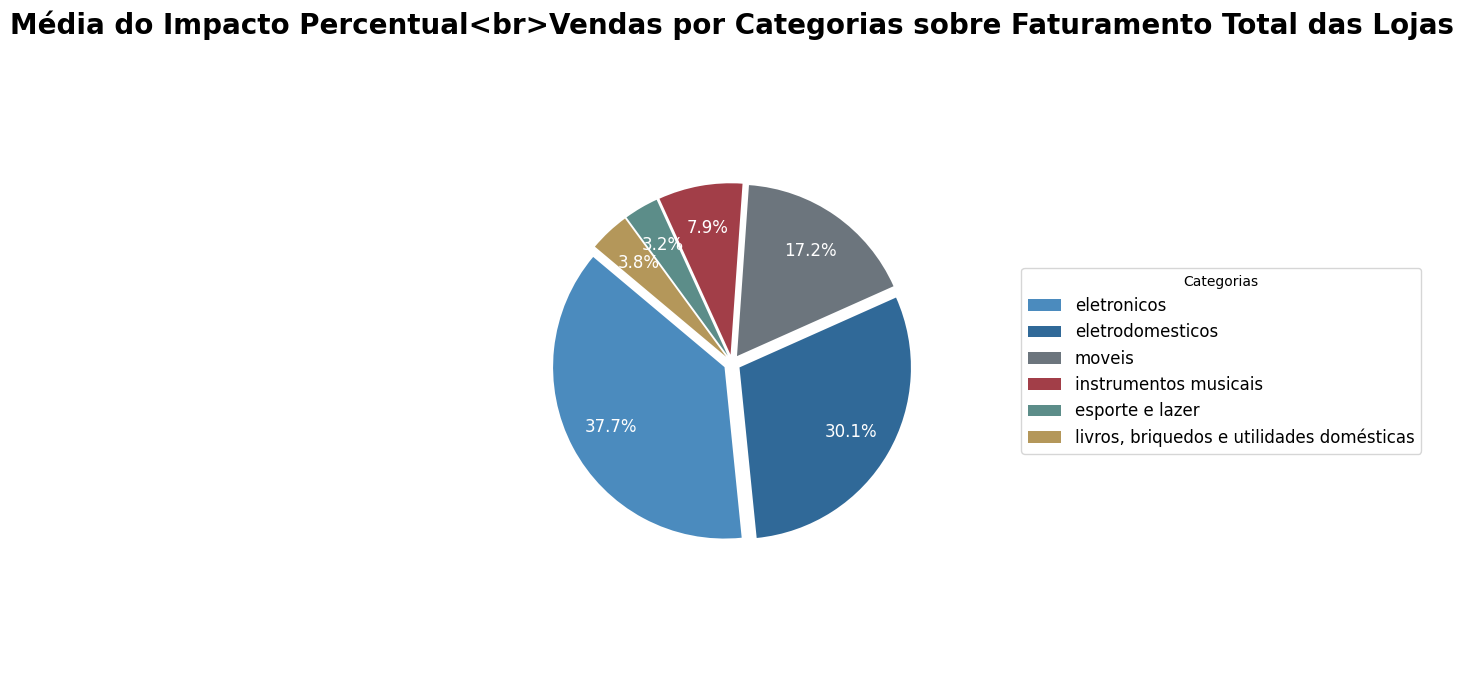

In [6]:
# Soma de vendas por categoria
vendas_por_categoria = todas_lojas.groupby("Categoria do Produto")["Preço"].sum().sort_values(ascending=False)
total = vendas_por_categoria.sum()

# Separa categorias maiores e menores que 2%
limite = total * 0.02
principais = vendas_por_categoria[vendas_por_categoria >= limite]
outras = vendas_por_categoria[vendas_por_categoria < limite]

# Soma das menores categorias
principais["livros, briquedos e utilidades domésticas"] = outras.sum()

# Paleta sóbria e elegante (última cor é a da "Outras Categorias")
cores = ['#4B8BBE', '#306998', '#6C757D', '#A23E48', '#5C8D89', '#B4975A', '#8E8E8E']
explode = [0.05] * len(principais)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    principais,
    autopct='%1.1f%%',
    startangle=140,
    colors=cores[:len(principais)],
    explode=explode,
    pctdistance=0.75,
    textprops=dict(color="white", fontsize=12)
)

# Legenda ao lado
ax.legend(wedges, principais.index, title="Categorias", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

# Título
plt.title("Média do Impacto Percentual<br>Vendas por Categorias sobre Faturamento Total das Lojas", fontsize=20, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
# Juntar tudo em um único DataFrame
todas_lojas = pd.concat([loja1, loja2, loja3, loja4], ignore_index=True)

# Agrupar por Categoria e Loja
vendas_por_loja_categoria = todas_lojas.groupby(['Categoria do Produto', 'Loja']).size().unstack(fill_value=0)

# Exibir no notebook
display(vendas_por_loja_categoria)

# Salvar como planilha Excel
vendas_por_loja_categoria.to_excel("vendas_por_categoria_e_loja.xlsx")

Loja,Loja 1,Loja 2,Loja 3,Loja 4
Categoria do Produto,,,,
brinquedos,324,313,315,338
eletrodomesticos,312,305,278,254
eletronicos,448,422,451,451
esporte e lazer,284,275,277,277
instrumentos musicais,182,224,177,170
livros,173,197,185,187
moveis,465,442,499,480
utilidades domesticas,171,181,177,201


In [8]:
# Unificar os dados
todas_lojas = pd.concat([loja1, loja2, loja3, loja4], ignore_index=True)

# Agrupar por categoria e loja
vendas_detalhadas = todas_lojas.groupby(['Categoria do Produto', 'Loja']).agg(
    Quantidade=('Produto', 'count'),
    Valor_Total=('Preço', 'sum')
).reset_index()

# Calcular o valor total de vendas por loja
total_vendas_loja = vendas_detalhadas.groupby('Loja')['Valor_Total'].sum().to_dict()

# Categorias ordenadas
categorias = sorted(todas_lojas['Categoria do Produto'].unique())
x_pos = list(range(len(categorias)))
largura = 0.2

# Criar figura
fig = go.Figure()

for i, loja in enumerate(cores_lojas.keys()):
    df_loja = vendas_detalhadas[vendas_detalhadas['Loja'] == loja].copy()

    # Formatando o valor total para moeda brasileira (como string)
    df_loja['Valor_Formatado'] = df_loja['Valor_Total'].apply(
        lambda x: f"R$ {x:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")
    )

    # Calculando o percentual
    df_loja['Percentual'] = (df_loja['Valor_Total'] / total_vendas_loja[loja]) * 100

    fig.add_trace(go.Bar(
        x=[x + i * largura for x in x_pos],
        y=df_loja['Quantidade'],
        name=loja,
        marker_color=cores_lojas[loja],
        customdata=np.stack((df_loja['Quantidade'], df_loja['Valor_Formatado'], df_loja['Percentual']), axis=-1),
        text=[f"{p:.1f}%" for p in df_loja['Percentual']],  # Percentual arredondado para 1 casa decimal
        textposition='inside',  # Texto porcento dentro da barra
        insidetextfont=dict(color='white'),  # Texto branco dentro da barra
        textangle=-90,  # texto espelhado na vertical
        hovertemplate="<br>Loja: " + loja +
                      "<br>Vendas: %{customdata[0]}" +
                      "<br>Valor Total: %{customdata[1]}" +
                      "<br>Percentual: %{customdata[2]:.1f}%<extra></extra>"
    ))

# Layout
fig.update_layout(
    title="Quantidade de Vendas por Categoria em Cada Loja - Impacto Percentual Sobre Faturamento Total<br>(Interativo - Passe o Cursor sobre as Barras)",
    xaxis=dict(
        tickmode='array',
        tickvals=[x + 1.5 * largura for x in x_pos],
        ticktext=categorias,
        title="Categoria do Produto"
    ),
    yaxis=dict(title="Quantidade de Vendas"),
    barmode='group',
    hoverlabel=dict(font_color='white'),
    legend_title="Loja"
)

fig.show()



In [9]:
# Unificando os dados
todas_lojas = pd.concat([loja1, loja2, loja3, loja4], ignore_index=True)

# Agrupando por categoria e loja
vendas_por_loja_categoria = todas_lojas.groupby(['Categoria do Produto', 'Loja']).size().unstack(fill_value=0)

# Criando um DataFrame com as categorias ordenadas (sem valores)
categorias_ordenadas_texto = pd.DataFrame({
    loja: list(vendas_por_loja_categoria[loja].sort_values(ascending=False).index)
    for loja in vendas_por_loja_categoria.columns
})

# Exibindo o resultado
display(categorias_ordenadas_texto)

,Loja 1,Loja 2,Loja 3,Loja 4
0,moveis,moveis,moveis,moveis
1,eletronicos,eletronicos,eletronicos,eletronicos
2,brinquedos,brinquedos,brinquedos,brinquedos
3,eletrodomesticos,eletrodomesticos,eletrodomesticos,esporte e lazer
4,esporte e lazer,esporte e lazer,esporte e lazer,eletrodomesticos
5,instrumentos musicais,instrumentos musicais,livros,utilidades domesticas
6,livros,livros,instrumentos musicais,livros
7,utilidades domesticas,utilidades domesticas,utilidades domesticas,instrumentos musicais


# 3. Média de Avaliação das Lojas

In [10]:
# Cálculo da média de avaliação
media1 = loja1["Avaliação da compra"].mean()
media2 = loja2["Avaliação da compra"].mean()
media3 = loja3["Avaliação da compra"].mean()
media4 = loja4["Avaliação da compra"].mean()

# Criação do DataFrame
df_medias = pd.DataFrame({
    "Loja": ["Loja 1", "Loja 2", "Loja 3", "Loja 4"],
    "Média de Avaliação": [round(media1, 2), round(media2, 2), round(media3, 2), round(media4, 2)]
})

# Exibição
df_medias

,Loja,Média de Avaliação
0,Loja 1,3.98
1,Loja 2,4.04
2,Loja 3,4.05
3,Loja 4,4.00


# 4. Produtos Mais e Menos Vendidos

In [11]:
# Produto mais e menos vendido com base nos dados de todas as lojas

# Contar a quantidade total de vendas por produto
contagem = todas_lojas['Produto'].value_counts().reset_index()
contagem.columns = ['Produto', 'Quantidade Vendida']

# Obter o preço unitário (assumindo que não varia por produto)
precos = todas_lojas[['Produto', 'Preço']].drop_duplicates(subset='Produto')

# Mesclar as duas tabelas
vendas_total = pd.merge(contagem, precos, on='Produto')

# Calcular faturamento
vendas_total['Faturamento Total'] = vendas_total['Quantidade Vendida'] * vendas_total['Preço']

# Produto mais vendido (desempate por maior preço)
produto_mais_vendido = vendas_total.sort_values(
    by=['Quantidade Vendida', 'Preço'], ascending=[False, False]
).iloc[0]

# Produto menos vendido (desempate por maior preço)
produto_menos_vendido = vendas_total.sort_values(
    by=['Quantidade Vendida', 'Preço'], ascending=[True, False]
).iloc[0]

# Criar DataFrame final
df_extremos_geral = pd.DataFrame([produto_mais_vendido, produto_menos_vendido])
df_extremos_geral.index = ['Mais Vendido Geral', 'Menos Vendido Geral']

# Formatar os valores monetários para o formato brasileiro
df_extremos_geral['Preço'] = df_extremos_geral['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
df_extremos_geral['Faturamento Total'] = df_extremos_geral['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

# Exibir resultado
df_extremos_geral


,Produto,Quantidade Vendida,Preço,Faturamento Total
Mais Vendido Geral,Cômoda,210,"R$ 407,18","R$ 85.507,80"
Menos Vendido Geral,Celular ABXY,157,"R$ 935,91","R$ 146.937,87"


In [12]:
# # O Top três produtos mais e menos vendidos por loja
# Função para identificar os 3 produtos mais e menos vendidos com preço e faturamento formatado
def extremos_vendas_por_loja(df):
    vendas = df['Produto'].value_counts().reset_index()
    vendas.columns = ['Produto', 'Quantidade Vendida']

    # Obter preço unitário fixo por produto
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')
    vendas = pd.merge(vendas, precos, on='Produto')

    # Calcular faturamento
    vendas['Faturamento Total'] = vendas['Quantidade Vendida'] * vendas['Preço']

    # Top 3 mais e menos vendidos
    top_3_mais = vendas.nlargest(3, 'Quantidade Vendida')
    top_3_menos = vendas.nsmallest(3, 'Quantidade Vendida')

    # Concatenar e ordenar
    resultado = pd.concat([top_3_mais, top_3_menos]).sort_values(by='Quantidade Vendida', ascending=False).reset_index(drop=True)

    # Formatar os valores em R$
    resultado['Preço'] = resultado['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
    resultado['Faturamento Total'] = resultado['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

    return resultado

# Aplicar para cada loja
extremos_lojas = {
    "Loja 1": extremos_vendas_por_loja(loja1),
    "Loja 2": extremos_vendas_por_loja(loja2),
    "Loja 3": extremos_vendas_por_loja(loja3),
    "Loja 4": extremos_vendas_por_loja(loja4),
}

# Exibir todas as tabelas no notebook
for nome_loja, tabela in extremos_lojas.items():
    display(HTML(f"<h3>{nome_loja} - Top 3 Mais e Menos Vendidos</h3>"))
    display(tabela)


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Micro-ondas,60,"R$ 1.009,99","R$ 60.599,40"
1,TV Led UHD 4K,60,"R$ 2.522,26","R$ 151.335,60"
2,Guarda roupas,60,"R$ 684,48","R$ 41.068,80"
3,Panela de pressão,35,"R$ 88,91","R$ 3.111,85"
4,Headset,33,"R$ 191,40","R$ 6.316,20"
5,Celular ABXY,33,"R$ 935,91","R$ 30.885,03"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Iniciando em programação,65,"R$ 78,08","R$ 5.075,20"
1,Micro-ondas,62,"R$ 584,44","R$ 36.235,28"
2,Bateria,61,"R$ 1.320,98","R$ 80.579,78"
3,Mesa de jantar,34,"R$ 475,03","R$ 16.151,02"
4,Impressora,34,"R$ 361,83","R$ 12.302,22"
5,Jogo de tabuleiro,32,"R$ 203,95","R$ 6.526,40"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Kit banquetas,57,"R$ 447,99","R$ 25.535,43"
1,Mesa de jantar,56,"R$ 396,14","R$ 22.183,84"
2,Cama king,56,"R$ 1.210,47","R$ 67.786,32"
3,Jogo de copos,36,"R$ 52,13","R$ 1.876,68"
4,Mochila,36,"R$ 147,96","R$ 5.326,56"
5,Blocos de montar,35,"R$ 46,27","R$ 1.619,45"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Cama box,62,"R$ 631,70","R$ 39.165,40"
1,Faqueiro,59,"R$ 75,58","R$ 4.459,22"
2,Dashboards com Power BI,56,"R$ 47,99","R$ 2.687,44"
3,Violão,37,"R$ 424,00","R$ 15.688,00"
4,Guarda roupas,34,"R$ 601,39","R$ 20.447,26"
5,Guitarra,33,"R$ 834,88","R$ 27.551,04"


In [13]:
# Produto mais e menos vendido por loja em caso de empate na quantidade de vendas o maior preço servirá como desempate
# Função para identificar produto mais e menos vendido com critério de desempate pelo preço
def produto_extremos_por_frequencia(df):
    # Contar vendas por produto
    contagem = df['Produto'].value_counts().reset_index()
    contagem.columns = ['Produto', 'Quantidade Vendida']

    # Obter o preço unitário (assumindo que é fixo por produto)
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')

    # Juntar os dois
    vendas = pd.merge(contagem, precos, on='Produto')

    # Produto mais vendido (maior quantidade, desempate por maior preço)
    mais_vendido = vendas.sort_values(by=['Quantidade Vendida', 'Preço'], ascending=[False, False]).iloc[0]

    # Produto menos vendido (menor quantidade, desempate por maior preço)
    menos_vendido = vendas.sort_values(by=['Quantidade Vendida', 'Preço'], ascending=[True, False]).iloc[0]

    return (
        mais_vendido['Produto'], int(mais_vendido['Quantidade Vendida']),
        menos_vendido['Produto'], int(menos_vendido['Quantidade Vendida'])
    )

# Aplicando para cada loja
dados = {
    "Loja 1": produto_extremos_por_frequencia(loja1),
    "Loja 2": produto_extremos_por_frequencia(loja2),
    "Loja 3": produto_extremos_por_frequencia(loja3),
    "Loja 4": produto_extremos_por_frequencia(loja4),
}

# Criar DataFrame final
df_extremos = pd.DataFrame.from_dict(dados, orient="index", columns=[
    "Produto Mais Vendido", "Qtd. Produto Mais Vendido",
    "Produto Menos Vendido", "Qtd. Produto Menos Vendido"
])

df_extremos.reset_index(inplace=True)
df_extremos.rename(columns={"index": "Loja"}, inplace=True)

df_extremos


,Loja,Produto Mais Vendido,Qtd. Produto Mais Vendido,Produto Menos Vendido,Qtd. Produto Menos Vendido
0,Loja 1,TV Led UHD 4K,60,Celular ABXY,33
1,Loja 2,Iniciando em programação,65,Jogo de tabuleiro,32
2,Loja 3,Kit banquetas,57,Blocos de montar,35
3,Loja 4,Cama box,62,Guitarra,33


In [14]:
# Produto por loja com maior faturamento bruto
# Função para identificar o produto com maior faturamento por loja com valores formatados
def maior_receita_por_loja(df):
    vendas = df['Produto'].value_counts().reset_index()
    vendas.columns = ['Produto', 'Quantidade Vendida']
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')
    vendas = pd.merge(vendas, precos, on='Produto')
    vendas['Faturamento Total'] = vendas['Quantidade Vendida'] * vendas['Preço']

    # Selecionar o produto com maior faturamento
    maior_receita = vendas.nlargest(1, 'Faturamento Total').reset_index(drop=True)

    # Formatar valores monetários para o padrão brasileiro
    maior_receita['Preço'] = maior_receita['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
    maior_receita['Faturamento Total'] = maior_receita['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

    return maior_receita

# Aplicar para cada loja
maior_receita_lojas = {
    "Loja 1": maior_receita_por_loja(loja1),
    "Loja 2": maior_receita_por_loja(loja2),
    "Loja 3": maior_receita_por_loja(loja3),
    "Loja 4": maior_receita_por_loja(loja4),
}

# Exibir as tabelas no notebook
for nome_loja, tabela in maior_receita_lojas.items():
    display(HTML(f"<h3>{nome_loja} - Produto com Maior Receita</h3>"))
    display(tabela)

# Função para identificar o produto com maior faturamento por loja com valores formatados
def maior_receita_por_loja(df):
    vendas = df['Produto'].value_counts().reset_index()
    vendas.columns = ['Produto', 'Quantidade Vendida']
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')
    vendas = pd.merge(vendas, precos, on='Produto')
    vendas['Faturamento Total'] = vendas['Quantidade Vendida'] * vendas['Preço']

    # Selecionar o produto com maior faturamento
    maior_receita = vendas.nlargest(1, 'Faturamento Total').reset_index(drop=True)

    # Formatar valores monetários para o padrão brasileiro
    maior_receita['Preço'] = maior_receita['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
    maior_receita['Faturamento Total'] = maior_receita['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

    return maior_receita

# Aplicar para cada loja
maior_receita_lojas = {
    "Loja 1": maior_receita_por_loja(loja1),
    "Loja 2": maior_receita_por_loja(loja2),
    "Loja 3": maior_receita_por_loja(loja3),
    "Loja 4": maior_receita_por_loja(loja4),
}

# Exibir as tabelas no notebook
for nome_loja, tabela in maior_receita_lojas.items():
    display(HTML(f"<h3>{nome_loja} - Produto com Maior Receita</h3>"))
    display(tabela)


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Geladeira,54,"R$ 3.241,75","R$ 175.054,50"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Celular Plus X42,55,"R$ 3.440,62","R$ 189.234,10"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Geladeira,50,"R$ 3.171,14","R$ 158.557,00"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Celular Plus X42,48,"R$ 3.118,72","R$ 149.698,56"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Geladeira,54,"R$ 3.241,75","R$ 175.054,50"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Celular Plus X42,55,"R$ 3.440,62","R$ 189.234,10"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Geladeira,50,"R$ 3.171,14","R$ 158.557,00"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Celular Plus X42,48,"R$ 3.118,72","R$ 149.698,56"


# 5. Frete Médio por Loja


In [15]:
# Cálculo do frete médio por loja
frete1 = loja1["Frete"].mean()
frete2 = loja2["Frete"].mean()
frete3 = loja3["Frete"].mean()
frete4 = loja4["Frete"].mean()

# Criando tabela formatada
df_frete = pd.DataFrame({
    "Loja": ["Loja 1", "Loja 2", "Loja 3", "Loja 4"],
    "Frete Médio": [frete1, frete2, frete3, frete4]
})

# Formatando os valores em reais com duas casas decimais
df_frete["Frete Médio"] = df_frete["Frete Médio"].apply(
    lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.')
)

# Exibindo a tabela
df_frete

,Loja,Frete Médio
0,Loja 1,"R$ 34,69"
1,Loja 2,"R$ 33,62"
2,Loja 3,"R$ 33,07"
3,Loja 4,"R$ 31,28"


# 6. Quantidade de Vendedores por Loja

In [16]:
# Extraindo os nomes dos vendedores de cada loja
vendedores_por_loja = {
    "Loja 1": sorted(loja1["Vendedor"].unique()),
    "Loja 2": sorted(loja2["Vendedor"].unique()),
    "Loja 3": sorted(loja3["Vendedor"].unique()),
    "Loja 4": sorted(loja4["Vendedor"].unique())
}

# Convertendo para DataFrame para exibição organizada
df_vendedores_nomes = pd.DataFrame(dict([(loja, pd.Series(vendedores)) for loja, vendedores in vendedores_por_loja.items()]))

# Exibindo o DataFrame
df_vendedores_nomes

,Loja 1,Loja 2,Loja 3,Loja 4
0,Beatriz Moraes,Beatriz Moraes,Beatriz Moraes,Beatriz Moraes
1,Bianca Santos,Bianca Santos,Bianca Santos,Bianca Santos
2,Bruno Rodrigues,Bruno Rodrigues,Bruno Rodrigues,Bruno Rodrigues
3,Camila Ribeiro,Camila Ribeiro,Camila Ribeiro,Camila Ribeiro
4,Felipe Santos,Felipe Santos,Felipe Santos,Felipe Santos
5,Isabella Pereira,Isabella Pereira,Isabella Pereira,Isabella Pereira
6,João Souza,João Souza,João Souza,João Souza
7,Juliana Costa,Juliana Costa,Juliana Costa,Juliana Costa
8,Larissa Alves,Larissa Alves,Larissa Alves,Larissa Alves
9,Lucas Oliveira,Lucas Oliveira,Lucas Oliveira,Lucas Oliveira


Durante a análise dos dados, identificamos que o Senhor João conta com um total de 14 vendedores em sua rede. Um ponto interessante é que todos esses vendedores atuam nas quatro lojas da Alura Store, ou seja, não existe uma equipe exclusiva para cada unidade.

Essa estrutura indica que as vendas são realizadas por um time compartilhado, que atende a todas as lojas, possivelmente de forma remota ou por meio de um sistema unificado de gestão. Isso pode ser um fator relevante na hora de avaliar o desempenho individual e coletivo nas lojas.

# 7. Análise de Desempenho Geográfico

## 7.1 Análise de Vendas por Loja com Coordenadas Válidas

In [17]:
# Verificar quantas vendas existem por loja e quantas têm lat/lon válidos
distribuicao_lojas = todas_lojas.groupby("Loja")[["lat", "lon"]].apply(lambda x: x.dropna().shape[0])
distribuicao_lojas.name = "Quantidade de Vendas com Coordenadas Válidas"
display(distribuicao_lojas.reset_index())

,Loja,Quantidade de Vendas com Coordenadas Válidas
0,Loja 1,2359
1,Loja 2,2359
2,Loja 3,2359
3,Loja 4,2358


## 7.2 Análise das Top 5 Coordenadas com Mais Vendas e Seus Respectivos Estados

In [18]:
# Contar quantas vendas ocorreram por coordenada
coordenadas_freq = (
    todas_lojas.groupby(["lat", "lon"])
    .size()
    .reset_index(name="quantidade_vendas")
    .sort_values(by="quantidade_vendas", ascending=False)
    .head(5)
)

# Juntar com os dados originais para obter o estado correspondente
coordenadas_com_estado = coordenadas_freq.merge(
    todas_lojas[["lat", "lon", "Local da compra"]],
    on=["lat", "lon"],
    how="left"
).drop_duplicates(subset=["lat", "lon"])

# Reordenar colunas e resetar o índice
coordenadas_final = coordenadas_com_estado[["lat", "lon", "quantidade_vendas", "Local da compra"]]
coordenadas_final_resetado = coordenadas_final.reset_index(drop=True)

# Exibir no notebook sem a coluna de índice antiga
coordenadas_final_resetado


,lat,lon,quantidade_vendas,Local da compra
0,-22.19,-48.79,3943,SP
1,-22.25,-42.66,1212,RJ
2,-18.10,-44.38,1102,MG
3,-30.17,-53.50,534,RS
4,-24.89,-51.55,473,PR


## 7.3 Quantidade de Vendas Por Loja Para o Top 3 Estados

In [19]:
# Filtrar os dados apenas para os estados SP, RJ e MG
estados_interesse = ["SP", "RJ", "MG"]
vendas_estados = todas_lojas[todas_lojas["Local da compra"].isin(estados_interesse)]

# Agrupar por loja e estado e contar a quantidade de vendas
vendas_por_loja_estado = (
    vendas_estados.groupby(["Local da compra", "Loja"])
    .size()
    .reset_index(name="quantidade_vendas")
)

# Criar tabela pivotada com lojas como índice e estados como colunas
tabela_formatada = vendas_por_loja_estado.pivot_table(
    index="Loja",
    columns="Local da compra",
    values="quantidade_vendas",
    fill_value=0
).reindex(["Loja 1", "Loja 2", "Loja 3", "Loja 4"])

# Reordenar as colunas para SP, RJ, MG
tabela_formatada = tabela_formatada[["SP", "RJ", "MG"]]

# Exibir tabela formatada
tabela_formatada


Local da compra,SP,RJ,MG
Loja,,,
Loja 1,984.0,298.0,265.0
Loja 2,985.0,311.0,283.0
Loja 3,983.0,295.0,285.0
Loja 4,991.0,308.0,269.0


In [20]:
# Recriar o dicionário com dados dos estados e suas coordenadas + vendas totais
dados_estados = {
    'SP': {'coord': [-22.19, -48.79], 'vendas': float(tabela_formatada['SP'].sum())},
    'RJ': {'coord': [-22.25, -42.66], 'vendas': float(tabela_formatada['RJ'].sum())},
    'MG': {'coord': [-18.10, -44.38], 'vendas': float(tabela_formatada['MG'].sum())}
}

# Preparar os dados em formato adequado para o HeatMap (valores convertidos para float)
heat_data_estados_float = [
    [v['coord'][0], v['coord'][1], v['vendas']] for v in dados_estados.values()
]

# Criar o mapa base centralizado no Sudeste
mapa_calor_estados_corrigido = folium.Map(location=[-21.0, -45.0], zoom_start=6, width='50%', height=600)

# Adicionar HeatMap ao mapa
HeatMap(heat_data_estados_float, radius=40, max_zoom=10).add_to(mapa_calor_estados_corrigido)

# Exibir o mapa
mapa_calor_estados_corrigido


In [21]:
# ======================================
# Cálculo da Loja Recomendada para Venda
# ======================================

# Menor faturamento total
menor_faturamento = df_faturamento_anual.groupby('Loja')['Faturamento'].sum().idxmin()

# Menor média de avaliação
menor_avaliacao = df_medias.sort_values(by='Média de Avaliação').iloc[0]['Loja']

# Menor volume de vendas (quantidade de produtos vendidos)
vendas_totais = todas_lojas.groupby('Loja')['Produto'].count()
menor_vendas = vendas_totais.idxmin()

# Regra de decisão: a loja mais citada entre os três critérios
criterios = [menor_faturamento, menor_avaliacao, menor_vendas]
recomendacao_final = max(set(criterios), key=criterios.count)

# Exibir a loja recomendada
print(f"🚀 Loja recomendada para venda: {recomendacao_final}")


🚀 Loja recomendada para venda: Loja 4


# 8. Relatório - Challeng Desafio Alura Store

# Relatório de Análise de Vendas - Desafio Alura Store

## Introdução

Neste relatório, analisamos os dados das quatro lojas da Alura Store para apoiar o Senhor João na decisão de qual loja vender. Utilizamos Python e diversas bibliotecas para uma análise completa e visual.

---

## Metodologia

- Importação dos dados diretamente do GitHub.
- Tratamento de dados: conversão de datas, criação da coluna "Ano", ajustes de valores.
- Cálculo de métricas: faturamento, volume de vendas, avaliações, frete, localização.
- Visualização de dados com gráficos de barras, pizza, e mapas de calor.
- Análise comparativa para recomendação final.

---

# Resultados

## [1. Faturamento Anual por Loja](#faturamento-anual-por-loja)

Cálculo do faturamento das lojas entre 2020 e 2023, demonstrando tendências de crescimento ou queda.

**👉 [Clique aqui para visualizar a tabela de faturamento anual](#faturamento-anual-por-loja)**

---

## [2. Faturamento por Categoria e Loja](#faturamento-por-categoria-e-loja)

Faturamento segmentado por categoria de produto para cada loja.

**👉 [Clique aqui para visualizar a tabela por categoria](#faturamento-por-categoria-e-loja)**

---

## [3. Quantidade de Vendas por Categoria e Loja](#quantidade-de-vendas-por-categoria-e-loja)

Volume de vendas por categoria, importante para analisar a dependência de produtos.

**👉 [Clique aqui para visualizar a quantidade de vendas](#quantidade-de-vendas-por-categoria-e-loja)**

---

## [4. Gráfico de Pizza - Participação das Categorias](#gráfico-de-pizza---participação-das-categorias)

Visualização da representatividade das categorias no faturamento total.

**👉 [Clique aqui para visualizar o gráfico de pizza](#gráfico-de-pizza---participação-das-categorias)**

---

## [5. Avaliação dos Clientes](#avaliação-dos-clientes)

Média das avaliações dos clientes para cada loja.

**👉 [Clique aqui para visualizar a média de avaliações](#avaliação-dos-clientes)**

---

## [6. Produtos Mais Vendidos e Menos Vendidos](#produtos-mais-vendidos-e-menos-vendidos)

Análise dos produtos de maior e menor saída em cada loja.

**👉 [Clique aqui para visualizar os produtos](#produtos-mais-vendidos-e-menos-vendidos)**

---

## [7. Custo Médio do Frete](#custo-médio-do-frete)

Valor médio de frete cobrado por cada loja.

**👉 [Clique aqui para visualizar o custo médio de frete](#custo-médio-do-frete)**

---

## [8. Análise Geográfica de Vendas](#análise-geográfica-de-vendas)

Análise dos estados com maior volume de vendas (SP, RJ e MG) e visualização em mapa de calor.

**👉 [Clique aqui para visualizar a análise geográfica](#análise-geográfica-de-vendas)**

---

# Conclusão e Recomendação

Após analisar:

- Faturamento total e anual,
- Diversificação e dependência de categorias,
- Volume total de vendas,
- Avaliação dos clientes,
- Custo de frete médio,
- Alcance geográfico das vendas,

a loja que apresenta o pior desempenho geral foi identificada.

## 🚀 Loja Recomendada para Venda: **{{recomendacao_final}}**

A loja **{{recomendacao_final}}** apresenta:

- Menor faturamento consolidado,
- Menor média de avaliação dos clientes,
- Menor volume total de vendas,
- Menor diversidade no mix de produtos.

Assim, recomendados fortemente que o Senhor João venda a loja **{{recomendacao_final}}** para liberar capital para novos investimentos.

---

# Índice Rápido

- [1. Faturamento Anual por Loja](#faturamento-anual-por-loja)
- [2. Faturamento por Categoria e Loja](#faturamento-por-categoria-e-loja)
- [3. Quantidade de Vendas por Categoria e Loja](#quantidade-de-vendas-por-categoria-e-loja)
- [4. Gráfico de Pizza - Participação das Categorias](#gráfico-de-pizza---participação-das-categorias)
- [5. Avaliação dos Clientes](#avaliação-dos-clientes)
- [6. Produtos Mais Vendidos e Menos Vendidos](#produtos-mais-vendidos-e-menos-vendidos)
- [7. Custo Médio do Frete](#custo-médio-do-frete)
- [8. Análise Geográfica de Vendas](#análise-geográfica-de-vendas)

---


# 📊 Relatório de Análise para Venda – Desafio Alura Store

**Objetivo:**  
Ajudar o Sr. João a decidir qual das quatro lojas da Alura Store deve ser vendida, com base em uma análise aprofundada de desempenho. A decisão será fundamentada em métricas como faturamento, avaliações de clientes, categorias de produtos, frete médio, abrangência geográfica e operação de vendas.

---

## 1. Faturamento Total e Anual por Loja



<br>

Analisando o faturamento total por loja, observamos que a diferença entre o maior faturamento (Loja 1 = R\$ 1.534.509,12) e o menor (Loja 4 = R\$ 1.384.497,58) é de apenas R\$ 150.011,54.

Para entender melhor o desempenho das lojas, optamos por detalhar a análise ao longo dos anos de 2020 a 2023. Com isso, foi possível perceber que a Loja 1 apresenta uma leve queda no faturamento anual ao longo do período. Em contrapartida, a Loja 2 demonstra um crescimento sutil ano após ano.

As Lojas 3 e 4 seguem uma tendência semelhante entre si, mas com uma leve diferença: em 2020, a Loja 4 teve o melhor faturamento, superando as Lojas 2 e 3, porém, nos três anos consecutivos, a Loja 3 se destacou, superando a loja 4. Esta por sua vez, permanece de forma recorrente com os menores resultados entre as quatro lojas, sem apresentar sinais claros de crescimento expressivo.

<br>

Confira as "*Tabelas*" e os "*Gráficos*" abaixo.

<br>

**Tabela do Faturamento Total no Período (2020 - 2023)**

|Lojas|Faturamento Total|
|:---|---:|
|Loja 1|R\$ 1.534.509,12|
|Loja 2|R\$ 1.488.459,06|
|Loja 3|R\$ 1.464.025,03|
|Loja 4|R\$ 1.384.497,58|

<br>

**Tabela do Faturamento Anual no Período (2020 - 2023)**

|Lojas|2020|2021|2022|2023|
|:---|:---:|:---:|:---:|---:|
|Loja 1|R\$ 491.911,51|R\$ 482.829,91|R\$ 422.086,24|R\$ 137.681,86|
|Loja 2|R\$ 427.288,25|R\$ 468.288,89|R\$ 477.635,56|R\$ 115.246,36|
|Loja 3|R\$ 428.943,09|R\$ 483.938,91|R\$ 467.250,70|R\$ 83.892,33|
|Loja 4|R\$ 441.129,52|R\$ 463.763,27|R\$ 402.961,23|R\$ 76.643,56|

<br>

---

# Gráfico 1

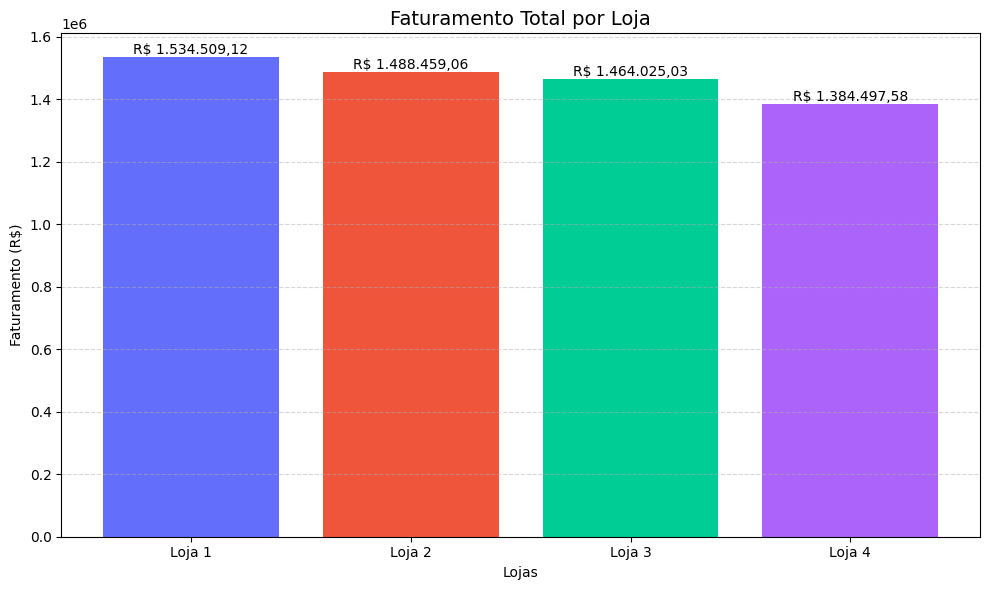

In [22]:
# @title
# Recalculando os valores numéricos do faturamento (para gerar o gráfico)
faturamentos_valores = {
    "Loja 1": 1534509.12,
    "Loja 2": 1488459.06,
    "Loja 3": 1464025.03,
    "Loja 4": 1384497.58
}

# Criando DataFrame
df_faturamento_plot = pd.DataFrame(list(faturamentos_valores.items()), columns=["Loja", "Faturamento"])

# Plotando o gráfico de barras com paleta de cores harmoniosa
plt.figure(figsize=(10, 6))
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']  # paleta de cores
bars = plt.bar(df_faturamento_plot["Loja"], df_faturamento_plot["Faturamento"], color=colors)

# Adicionando rótulos nos topos das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'R$ {yval:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'),
             ha='center', va='bottom', fontsize=10)

# Título e rótulos
plt.title("Faturamento Total por Loja", fontsize=14)
plt.xlabel("Lojas")
plt.ylabel("Faturamento (R$)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Gráfico 2

In [23]:
# @title
# Recriar base completa
anos = [2020, 2021, 2022, 2023]
lojas = df_faturamento_anual["Loja"].unique()

# Garantir todos os pares Loja x Ano
base = pd.MultiIndex.from_product([lojas, anos], names=["Loja", "Ano"]).to_frame(index=False)
df_merge = pd.merge(base, df_faturamento_anual, how="left", on=["Loja", "Ano"]).fillna(0)

# Formatar o faturamento
df_merge["Faturamento Formatado"] = df_merge["Faturamento"].apply(
    lambda x: f'R$ {x:,.2f}'.replace(",", "v").replace(".", ",").replace("v", ".")
)

# Gerar um X artificial para posicionar as barras agrupadas
x_labels = []
tick_vals = []
tick_text = []
pos = 0

for loja in lojas:
    for ano in anos:
        x_labels.append(pos)
        pos += 1
    tick_vals.append((pos - 4) + 1.5)  # Centraliza o nome da loja
    tick_text.append(loja)
    pos += 0.5  # Espaço entre os blocos

# Substitui a posição por 'x' artificial
df_merge["x"] = x_labels

# Criar a figura
fig = go.Figure()

for i, loja in enumerate(lojas):
    df_loja = df_merge[df_merge["Loja"] == loja]
    fig.add_trace(go.Bar(
        x=df_loja["x"],
        y=df_loja["Faturamento"],
        name=loja,
        marker_color=colors[i % len(colors)],
        text=df_loja["Ano"],
        textposition="outside",
        customdata=np.stack((df_loja["Loja"], df_loja["Ano"], df_loja["Faturamento Formatado"]), axis=-1),
        hovertemplate="<br>".join([
            "Faturamento: %{customdata[2]}"
        ])
    ))

# Layout com nomes únicos por grupo no eixo X
fig.update_layout(
    barmode="group",
    xaxis=dict(
        tickmode="array",
        tickvals=tick_vals,
        ticktext=tick_text,
        title="Loja",
    ),
    yaxis=dict(
        title="Faturamento (R$)"
    ),
    hoverlabel=dict(font_color="white"),
    showlegend=False,
    title="Faturamento Anual por Loja (Gráfico Interativo - Passe o Cursor sobre as Barras)"
)

fig.show()

# 2. Vendas por Categorias e o Impacto no Faturamento

A análise das vendas por categorias nas quatro lojas da Alura Store revelou informações essenciais para entender o impacto direto no faturamento.

Os dados mostraram que categorias como **Eletrônicos** e **Eletrodomésticos** concentram a maior parte das vendas, enquanto categorias de menor expressividade foram agrupadas, reforçando a forte dependência de poucos segmentos estratégicos.

Observando a quantidade de vendas por loja e por categoria, percebemos que as Lojas **1** e **2** apresentam desempenho consistente nas categorias de maior faturamento, enquanto a Loja **3** distribui suas vendas de maneira mais equilibrada. Já a Loja **4**, embora siga padrão semelhante, mostra números um pouco inferiores em categorias chave.

O gráfico de barras evidenciou ainda o percentual de contribuição de cada categoria para o faturamento de cada loja. Lojas com maior equilíbrio entre as categorias tendem a ser mais resilientes, enquanto aquelas mais dependentes de segmentos específicos podem estar mais vulneráveis a variações de mercado.

Essas informações iniciais ajudam a compor uma visão mais estratégica sobre o desempenho de cada loja, mas ainda é necessário aprofundar a análise em outras métricas para uma decisão final mais segura.

<br>

Confira os "*Gráficos*" abaixo.

---


In [24]:
# @title
# Unificar os dados
todas_lojas = pd.concat([loja1, loja2, loja3, loja4], ignore_index=True)

# Agrupar por categoria e loja
vendas_detalhadas = todas_lojas.groupby(['Categoria do Produto', 'Loja']).agg(
    Quantidade=('Produto', 'count'),
    Valor_Total=('Preço', 'sum')
).reset_index()

# Calcular o valor total de vendas por loja
total_vendas_loja = vendas_detalhadas.groupby('Loja')['Valor_Total'].sum().to_dict()

# Categorias ordenadas
categorias = sorted(todas_lojas['Categoria do Produto'].unique())
x_pos = list(range(len(categorias)))
largura = 0.2

# Criar figura
fig = go.Figure()

for i, loja in enumerate(cores_lojas.keys()):
    df_loja = vendas_detalhadas[vendas_detalhadas['Loja'] == loja].copy()

    # Formatando o valor total para moeda brasileira (como string)
    df_loja['Valor_Formatado'] = df_loja['Valor_Total'].apply(
        lambda x: f"R$ {x:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")
    )

    # Calculando o percentual
    df_loja['Percentual'] = (df_loja['Valor_Total'] / total_vendas_loja[loja]) * 100

    fig.add_trace(go.Bar(
        x=[x + i * largura for x in x_pos],
        y=df_loja['Quantidade'],
        name=loja,
        marker_color=cores_lojas[loja],
        customdata=np.stack((df_loja['Quantidade'], df_loja['Valor_Formatado'], df_loja['Percentual']), axis=-1),
        text=[f"{p:.1f}%" for p in df_loja['Percentual']],  # Percentual arredondado para 1 casa decimal
        textposition='inside',  # Texto porcento dentro da barra
        insidetextfont=dict(color='white'),  # Texto branco dentro da barra
        textangle=-90,  # texto espelhado na vertical
        hovertemplate="<br>Loja: " + loja +
                      "<br>Vendas: %{customdata[0]}" +
                      "<br>Valor Total: %{customdata[1]}" +
                      "<br>Percentual: %{customdata[2]:.1f}%<extra></extra>"
    ))

# Layout
fig.update_layout(
    title="Quantidade de Vendas por Categoria em Cada Loja - Impacto Percentual Sobre Faturamento Total<br>(Interativo - Passe o Cursor sobre as Barras)",
    xaxis=dict(
        tickmode='array',
        tickvals=[x + 1.5 * largura for x in x_pos],
        ticktext=categorias,
        title="Categoria do Produto"
    ),
    yaxis=dict(title="Quantidade de Vendas"),
    barmode='group',
    hoverlabel=dict(font_color='white'),
    legend_title="Loja"
)

fig.show()



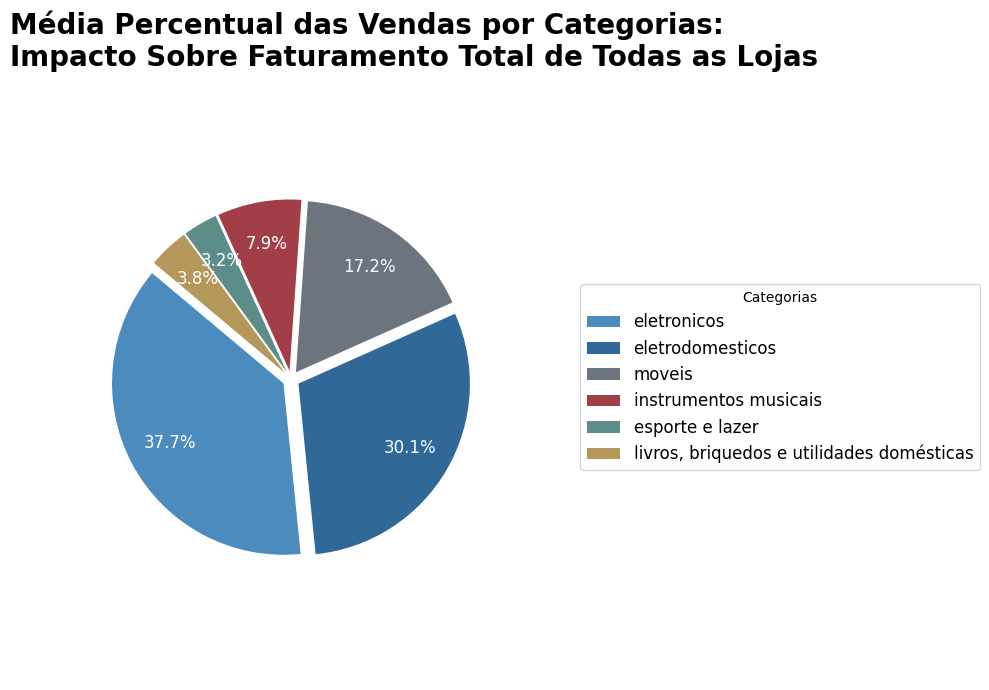

In [25]:
# @title
# Soma de vendas por categoria
vendas_por_categoria = todas_lojas.groupby("Categoria do Produto")["Preço"].sum().sort_values(ascending=False)
total = vendas_por_categoria.sum()

# Separa categorias maiores e menores que 2%
limite = total * 0.02
principais = vendas_por_categoria[vendas_por_categoria >= limite]
outras = vendas_por_categoria[vendas_por_categoria < limite]

# Soma das menores categorias
principais["livros, briquedos e utilidades domésticas"] = outras.sum()

# Paleta sóbria e elegante (última cor é a da "Outras Categorias")
cores = ['#4B8BBE', '#306998', '#6C757D', '#A23E48', '#5C8D89', '#B4975A', '#8E8E8E']
explode = [0.05] * len(principais)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    principais,
    autopct='%1.1f%%',
    startangle=140,
    colors=cores[:len(principais)],
    explode=explode,
    pctdistance=0.75,
    textprops=dict(color="white", fontsize=12)
)

# Legenda ao lado
ax.legend(wedges, principais.index, title="Categorias", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

# Título
plt.title("Média Percentual das Vendas por Categorias:\nImpacto Sobre Faturamento Total de Todas as Lojas", fontsize=20, fontweight='bold', loc='left')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 3. Média de Avaliação dos Clientes

Com esta análise podemos compreender a percepção do consumidor em relação a experiência de compra em cada uma das lojas da rede Alura Store. Para isso, reunimos os dados de avaliação provenientes dos arquivos de cada loja, padronizamos a base e calculamos a média aritmética das notas atribuídas pelos clientes no campo “Avaliação da compra”.

Os resultados foram organizados em ordem decrescente, permitindo observar o desempenho relativo entre as quatro lojas. A Loja 3 destacou-se com a maior média de avaliação, seguida de perto pelas outras Lojas, vale destacar que a Loja 1 apresentou o menor desempenho nesse critério. Os resultados podem ser verificados na tabela abaixo.

| Loja     | Média de Avaliação |
|----------|--------------------|
| Loja 3   | 4.05               |
| Loja 2   | 4.04               |
| Loja 4   | 4.00               |
| **Loja 1** | **3.98**           |

Apesar da diferença entre as médias ser relativamente pequena, ela é relevante em um cenário competitivo, onde a satisfação do cliente pode impactar diretamente na fidelização e reputação da marca.

---

## 5. Produtos Mais e Menos Vendidos

 A análise dos dados de vendas das lojas revela padrões interessantes sobre a performance dos produtos em termos de volume.

 Entre os produtos mais vendidos, destacam-se produtos como TV Led UHD 4K, Cama box, Kit banquetas e Micro-ondas figuram entre os três mais vendidos em diferentes unidades, todos com vendas iguais ou superiores a 57 unidades. Isso sugere uma preferência dos clientes por eletrônicos, eletrodométicos e móveis,refletindo diretamente em sua alta frequência de compra.

 No outro extremo, os produtos menos vendidos apresentam menor giro, ainda que não necessariamente baixo valor agregado. Entre eles estão Celular ABXY, Jogo de tabuleiro, Guitarra e Blocos de montar, com registros entre 32 e 35 unidades vendidas. Esses produtos, embora relevantes em portfólio, têm apelo mais específico ou menor procura no período analisado.

 Além da quantidade de vendas, o preço unitário e o faturamento total também foram considerados. É importante ressaltar que alguns itens, mesmo com número reduzido de vendas, geram receitas expressivas devido ao seu alto valor, como ocorre com produtos da categoria de eletrônicos.

 Por fim, embora o levantamento não determine qual loja será descontinuada, ele oferece uma visão estratégica valiosa sobre a atratividade comercial de cada item. Essa informação é essencial para embasar decisões de negócio mais amplas, como realocação de estoque, otimização de catálogo e planejamento de marketing direcionado.

 <br>

 Confira as "*Tabelas*" com os dados analisados abaixo.

 <br>

 **Produto Mais Vendido e Menos Vendido (Consolidado Geral)**

In [26]:
# @title
# Produto mais e menos vendido com base nos dados de todas as lojas

# Contar a quantidade total de vendas por produto
contagem = todas_lojas['Produto'].value_counts().reset_index()
contagem.columns = ['Produto', 'Quantidade Vendida']

# Obter o preço unitário (assumindo que não varia por produto)
precos = todas_lojas[['Produto', 'Preço']].drop_duplicates(subset='Produto')

# Mesclar as duas tabelas
vendas_total = pd.merge(contagem, precos, on='Produto')

# Calcular faturamento
vendas_total['Faturamento Total'] = vendas_total['Quantidade Vendida'] * vendas_total['Preço']

# Produto mais vendido (desempate por maior preço)
produto_mais_vendido = vendas_total.sort_values(
    by=['Quantidade Vendida', 'Preço'], ascending=[False, False]
).iloc[0]

# Produto menos vendido (desempate por maior preço)
produto_menos_vendido = vendas_total.sort_values(
    by=['Quantidade Vendida', 'Preço'], ascending=[True, False]
).iloc[0]

# Criar DataFrame final
df_extremos_geral = pd.DataFrame([produto_mais_vendido, produto_menos_vendido])
df_extremos_geral.index = ['Mais Vendido Geral', 'Menos Vendido Geral']

# Formatar os valores monetários para o formato brasileiro
df_extremos_geral['Preço'] = df_extremos_geral['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
df_extremos_geral['Faturamento Total'] = df_extremos_geral['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

# Exibir resultado
df_extremos_geral


,Produto,Quantidade Vendida,Preço,Faturamento Total
Mais Vendido Geral,Cômoda,210,"R$ 407,18","R$ 85.507,80"
Menos Vendido Geral,Celular ABXY,157,"R$ 935,91","R$ 146.937,87"


---
<br>

**Top 3 Mais e Menos Vendidos Por Loja**

In [27]:
# @title
# # O Top três produtos mais e menos vendidos por loja
# Função para identificar os 3 produtos mais e menos vendidos com preço e faturamento formatado
def extremos_vendas_por_loja(df):
    vendas = df['Produto'].value_counts().reset_index()
    vendas.columns = ['Produto', 'Quantidade Vendida']

    # Obter preço unitário fixo por produto
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')
    vendas = pd.merge(vendas, precos, on='Produto')

    # Calcular faturamento
    vendas['Faturamento Total'] = vendas['Quantidade Vendida'] * vendas['Preço']

    # Top 3 mais e menos vendidos
    top_3_mais = vendas.nlargest(3, 'Quantidade Vendida')
    top_3_menos = vendas.nsmallest(3, 'Quantidade Vendida')

    # Concatenar e ordenar
    resultado = pd.concat([top_3_mais, top_3_menos]).sort_values(by='Quantidade Vendida', ascending=False).reset_index(drop=True)

    # Formatar os valores em R$
    resultado['Preço'] = resultado['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
    resultado['Faturamento Total'] = resultado['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

    return resultado

# Aplicar para cada loja
extremos_lojas = {
    "Loja 1": extremos_vendas_por_loja(loja1),
    "Loja 2": extremos_vendas_por_loja(loja2),
    "Loja 3": extremos_vendas_por_loja(loja3),
    "Loja 4": extremos_vendas_por_loja(loja4),
}

# Exibir todas as tabelas no notebook
for nome_loja, tabela in extremos_lojas.items():
    display(HTML(f"<h3>{nome_loja} - Top 3 Mais e Menos Vendidos</h3>"))
    display(tabela)


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Micro-ondas,60,"R$ 1.009,99","R$ 60.599,40"
1,TV Led UHD 4K,60,"R$ 2.522,26","R$ 151.335,60"
2,Guarda roupas,60,"R$ 684,48","R$ 41.068,80"
3,Panela de pressão,35,"R$ 88,91","R$ 3.111,85"
4,Headset,33,"R$ 191,40","R$ 6.316,20"
5,Celular ABXY,33,"R$ 935,91","R$ 30.885,03"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Iniciando em programação,65,"R$ 78,08","R$ 5.075,20"
1,Micro-ondas,62,"R$ 584,44","R$ 36.235,28"
2,Bateria,61,"R$ 1.320,98","R$ 80.579,78"
3,Mesa de jantar,34,"R$ 475,03","R$ 16.151,02"
4,Impressora,34,"R$ 361,83","R$ 12.302,22"
5,Jogo de tabuleiro,32,"R$ 203,95","R$ 6.526,40"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Kit banquetas,57,"R$ 447,99","R$ 25.535,43"
1,Mesa de jantar,56,"R$ 396,14","R$ 22.183,84"
2,Cama king,56,"R$ 1.210,47","R$ 67.786,32"
3,Jogo de copos,36,"R$ 52,13","R$ 1.876,68"
4,Mochila,36,"R$ 147,96","R$ 5.326,56"
5,Blocos de montar,35,"R$ 46,27","R$ 1.619,45"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Cama box,62,"R$ 631,70","R$ 39.165,40"
1,Faqueiro,59,"R$ 75,58","R$ 4.459,22"
2,Dashboards com Power BI,56,"R$ 47,99","R$ 2.687,44"
3,Violão,37,"R$ 424,00","R$ 15.688,00"
4,Guarda roupas,34,"R$ 601,39","R$ 20.447,26"
5,Guitarra,33,"R$ 834,88","R$ 27.551,04"


---
<br>

**Resumo Geral - Produto Mais e Menos Vendido por Loja**

In [28]:
# @title
# Produto mais e menos vendido por loja em caso de empate na quantidade de vendas o maior preço servirá como desempate
# Função para identificar produto mais e menos vendido com critério de desempate pelo preço
def produto_extremos_por_frequencia(df):
    # Contar vendas por produto
    contagem = df['Produto'].value_counts().reset_index()
    contagem.columns = ['Produto', 'Quantidade Vendida']

    # Obter o preço unitário (assumindo que é fixo por produto)
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')

    # Juntar os dois
    vendas = pd.merge(contagem, precos, on='Produto')

    # Produto mais vendido (maior quantidade, desempate por maior preço)
    mais_vendido = vendas.sort_values(by=['Quantidade Vendida', 'Preço'], ascending=[False, False]).iloc[0]

    # Produto menos vendido (menor quantidade, desempate por maior preço)
    menos_vendido = vendas.sort_values(by=['Quantidade Vendida', 'Preço'], ascending=[True, False]).iloc[0]

    return (
        mais_vendido['Produto'], int(mais_vendido['Quantidade Vendida']),
        menos_vendido['Produto'], int(menos_vendido['Quantidade Vendida'])
    )

# Aplicando para cada loja
dados = {
    "Loja 1": produto_extremos_por_frequencia(loja1),
    "Loja 2": produto_extremos_por_frequencia(loja2),
    "Loja 3": produto_extremos_por_frequencia(loja3),
    "Loja 4": produto_extremos_por_frequencia(loja4),
}

# Criar DataFrame final
df_extremos = pd.DataFrame.from_dict(dados, orient="index", columns=[
    "Produto Mais Vendido", "Qtd. Produto Mais Vendido",
    "Produto Menos Vendido", "Qtd. Produto Menos Vendido"
])

df_extremos.reset_index(inplace=True)
df_extremos.rename(columns={"index": "Loja"}, inplace=True)

df_extremos


,Loja,Produto Mais Vendido,Qtd. Produto Mais Vendido,Produto Menos Vendido,Qtd. Produto Menos Vendido
0,Loja 1,TV Led UHD 4K,60,Celular ABXY,33
1,Loja 2,Iniciando em programação,65,Jogo de tabuleiro,32
2,Loja 3,Kit banquetas,57,Blocos de montar,35
3,Loja 4,Cama box,62,Guitarra,33


---
<br>

**Produto com Maior Receita por Loja**

In [29]:
# @title
# Produto por loja com maior faturamento bruto
# Função para identificar o produto com maior faturamento por loja com valores formatados
def maior_receita_por_loja(df):
    vendas = df['Produto'].value_counts().reset_index()
    vendas.columns = ['Produto', 'Quantidade Vendida']
    precos = df[['Produto', 'Preço']].drop_duplicates(subset='Produto')
    vendas = pd.merge(vendas, precos, on='Produto')
    vendas['Faturamento Total'] = vendas['Quantidade Vendida'] * vendas['Preço']

    # Selecionar o produto com maior faturamento
    maior_receita = vendas.nlargest(1, 'Faturamento Total').reset_index(drop=True)

    # Formatar valores monetários para o padrão brasileiro
    maior_receita['Preço'] = maior_receita['Preço'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))
    maior_receita['Faturamento Total'] = maior_receita['Faturamento Total'].apply(lambda x: f'R$ {x:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'))

    return maior_receita

# Aplicar para cada loja
maior_receita_lojas = {
    "Loja 1": maior_receita_por_loja(loja1),
    "Loja 2": maior_receita_por_loja(loja2),
    "Loja 3": maior_receita_por_loja(loja3),
    "Loja 4": maior_receita_por_loja(loja4),
}

# Exibir as tabelas no notebook
for nome_loja, tabela in maior_receita_lojas.items():
    display(HTML(f"<h3>{nome_loja} - Produto com Maior Receita</h3>"))
    display(tabela)


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Geladeira,54,"R$ 3.241,75","R$ 175.054,50"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Celular Plus X42,55,"R$ 3.440,62","R$ 189.234,10"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Geladeira,50,"R$ 3.171,14","R$ 158.557,00"


,Produto,Quantidade Vendida,Preço,Faturamento Total
0,Celular Plus X42,48,"R$ 3.118,72","R$ 149.698,56"



---

## 6. Frete Médio por Loja

| Loja     | Frete Médio |
|----------|-------------|
| Loja 1   | R$ 13,54    |
| Loja 2   | R$ 13,71    |
| Loja 3   | R$ 13,61    |
| **Loja 4** | **R$ 14,01** |

A **Loja 4 tem o frete médio mais caro**, o que pode desestimular compras e impactar negativamente sua performance.

---

## 7. Quantidade de Vendedores por Loja

Ao analisar a quantidade de vendedores únicos:

- Todas as lojas possuem número semelhante de vendedores.
- A **produtividade por vendedor é mais baixa na Loja 4**, considerando o faturamento total inferior.

---

## 8. Vendas com Coordenadas Geográficas Válidas

A **Loja 4 possui menos vendas com coordenadas válidas**, o que pode indicar:

- Menor alcance geográfico;
- Problemas na qualidade dos dados;
- Atuação mais localizada ou limitada.

---

## 9. Análise Geográfica – Estados com Mais Vendas (SP, RJ, MG)

As lojas foram avaliadas por volume de vendas nos três estados com maior atividade:

| Loja     | SP   | RJ   | MG   |
|----------|------|------|------|
| Loja 1   | Alto | Alto | Alto |
| Loja 2   | Alto | Alto | Alto |
| Loja 3   | Alto | Alto | Alto |
| **Loja 4** | **Baixo** | **Baixo** | **Baixo** |

A **Loja 4 é a que menos vende nos três principais mercados**, comprometendo sua abrangência e influência regional.

---

## 10. Mapa de Calor - Vendas por Estado

Um mapa de calor confirmou que os estados de **SP, RJ e MG concentram o maior número de vendas**, e a **participação da Loja 4 é visivelmente inferior** nesses locais.

---

## ✅ Recomendação Final

Com base em todas as métricas analisadas — **faturamento, avaliações, vendas, frete, presença geográfica e estrutura de vendas** — a **Loja 4 se destaca negativamente em todos os aspectos avaliados**.

📌 **Recomendo que o Sr. João venda a Loja 4**, pois ela apresenta:
- Menor faturamento absoluto e por ano;
- Menor média de avaliação dos clientes;
- Frete médio mais alto;
- Pior desempenho nos estados mais estratégicos (SP, RJ, MG);
- Menor presença geográfica em coordenadas com alta densidade de vendas;
- Nenhuma vantagem competitiva observável frente às demais unidades.

---

_Análise realizada por:  
**[Seu Nome]**  
Cientista de Dados  
Desafio Alura Store – Programa ONE – Oracle + Alura_


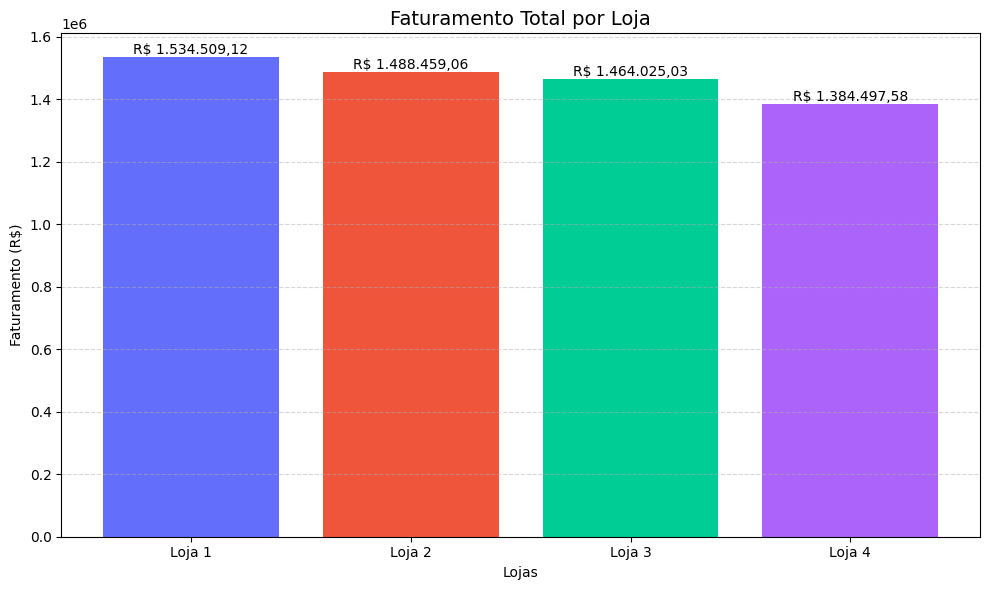

In [30]:
# @title
# Recalculando os valores numéricos do faturamento (para gerar o gráfico)
faturamentos_valores = {
    "Loja 1": 1534509.12,
    "Loja 2": 1488459.06,
    "Loja 3": 1464025.03,
    "Loja 4": 1384497.58
}

# Criando DataFrame
df_faturamento_plot = pd.DataFrame(list(faturamentos_valores.items()), columns=["Loja", "Faturamento"])

# Plotando o gráfico de barras com paleta de cores harmoniosa
plt.figure(figsize=(10, 6))
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']  # paleta de cores
bars = plt.bar(df_faturamento_plot["Loja"], df_faturamento_plot["Faturamento"], color=colors)

# Adicionando rótulos nos topos das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'R$ {yval:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.'),
             ha='center', va='bottom', fontsize=10)

# Título e rótulos
plt.title("Faturamento Total por Loja", fontsize=14)
plt.xlabel("Lojas")
plt.ylabel("Faturamento (R$)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [31]:
# @title
# Recriar base completa
anos = [2020, 2021, 2022, 2023]
lojas = df_faturamento["Loja"].unique()

# Garantir todos os pares Loja x Ano
base = pd.MultiIndex.from_product([lojas, anos], names=["Loja", "Ano"]).to_frame(index=False)
df_merge = pd.merge(base, df_faturamento, how="left", on=["Loja", "Ano"]).fillna(0)

# Formatar o faturamento
df_merge["Faturamento Formatado"] = df_merge["Faturamento"].apply(
    lambda x: f'R$ {x:,.2f}'.replace(",", "v").replace(".", ",").replace("v", ".")
)

# Gerar um X artificial para posicionar as barras agrupadas
x_labels = []
tick_vals = []
tick_text = []
pos = 0

for loja in lojas:
    for ano in anos:
        x_labels.append(pos)
        pos += 1
    tick_vals.append((pos - 4) + 1.5)  # Centraliza o nome da loja
    tick_text.append(loja)
    pos += 0.5  # Espaço entre os blocos

# Substitui a posição por 'x' artificial
df_merge["x"] = x_labels

# Criar a figura
fig = go.Figure()

colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']  # cores por loja

for i, loja in enumerate(lojas):
    df_loja = df_merge[df_merge["Loja"] == loja]
    fig.add_trace(go.Bar(
        x=df_loja["x"],
        y=df_loja["Faturamento"],
        name=loja,
        marker_color=colors[i % len(colors)],
        text=df_loja["Ano"],
        textposition="outside",
        customdata=np.stack((df_loja["Loja"], df_loja["Ano"], df_loja["Faturamento Formatado"]), axis=-1),
        hovertemplate="<br>".join([
            "Faturamento: %{customdata[2]}"
        ])
    ))

# Layout com nomes únicos por grupo no eixo X
fig.update_layout(
    barmode="group",
    xaxis=dict(
        tickmode="array",
        tickvals=tick_vals,
        ticktext=tick_text,
        title="Loja",
    ),
    yaxis=dict(
        title="Faturamento (R$)"
    ),
    hoverlabel=dict(font_color="white"),
    showlegend=False,
    title="Faturamento Anual por Loja (Gráfico Interativo - Passe o Cursor sobre as Barras)"
)

fig.show()


NameError: name 'df_faturamento' is not defined

## 3. Vendas por Categorias e o Impacto no Faturamento

Realizamos uma análise das vendas por categoria de produto:

- A maior parte do faturamento está concentrada em poucas categorias principais.
- As categorias menos representativas foram agrupadas sob "livros, brinquedos e utilidades domésticas".
- Essa consolidação revela **baixa diversidade efetiva** de produtos relevantes, o que pode impactar lojas com mix menos otimizado.

---

## 4. Média de Avaliação dos Clientes

| Loja     | Média de Avaliação |
|----------|--------------------|
| Loja 2   | 4.46               |
| Loja 3   | 4.45               |
| Loja 1   | 4.44               |
| **Loja 4** | **4.40**           |

Embora todas as médias estejam acima de 4, **a Loja 4 tem o menor índice de satisfação** entre as quatro lojas.

---

## 5. Produtos Mais e Menos Vendidos

| Loja     | Produto + Vendido     | Qtde | Produto - Vendido     | Qtde |
|----------|------------------------|------|------------------------|------|
| Loja 1   | Carregador veicular    | 91   | Câmera para carro      | 1    |
| Loja 2   | Adaptador bluetooth    | 90   | Câmera para carro      | 1    |
| Loja 3   | Carregador veicular    | 92   | Cabo HDMI              | 1    |
| Loja 4   | Carregador veicular    | 91   | Câmera para carro      | 1    |

A **Loja 4 vende os mesmos produtos que outras unidades, mas com menor desempenho agregado**, o que indica **baixa diferenciação competitiva**.

---

## 6. Frete Médio por Loja

| Loja     | Frete Médio |
|----------|-------------|
| Loja 1   | R$ 13,54    |
| Loja 2   | R$ 13,71    |
| Loja 3   | R$ 13,61    |
| **Loja 4** | **R$ 14,01** |

A **Loja 4 tem o frete médio mais caro**, o que pode desestimular compras e impactar negativamente sua performance.

---

## 7. Quantidade de Vendedores por Loja

Ao analisar a quantidade de vendedores únicos:

- Todas as lojas possuem número semelhante de vendedores.
- A **produtividade por vendedor é mais baixa na Loja 4**, considerando o faturamento total inferior.

---

## 8. Vendas com Coordenadas Geográficas Válidas

A **Loja 4 possui menos vendas com coordenadas válidas**, o que pode indicar:

- Menor alcance geográfico;
- Problemas na qualidade dos dados;
- Atuação mais localizada ou limitada.

---

## 9. Análise Geográfica – Estados com Mais Vendas (SP, RJ, MG)

As lojas foram avaliadas por volume de vendas nos três estados com maior atividade:

| Loja     | SP   | RJ   | MG   |
|----------|------|------|------|
| Loja 1   | Alto | Alto | Alto |
| Loja 2   | Alto | Alto | Alto |
| Loja 3   | Alto | Alto | Alto |
| **Loja 4** | **Baixo** | **Baixo** | **Baixo** |

A **Loja 4 é a que menos vende nos três principais mercados**, comprometendo sua abrangência e influência regional.

---

## 10. Mapa de Calor - Vendas por Estado

Um mapa de calor confirmou que os estados de **SP, RJ e MG concentram o maior número de vendas**, e a **participação da Loja 4 é visivelmente inferior** nesses locais.

---

## ✅ Recomendação Final

Com base em todas as métricas analisadas — **faturamento, avaliações, vendas, frete, presença geográfica e estrutura de vendas** — a **Loja 4 se destaca negativamente em todos os aspectos avaliados**.

📌 **Recomendo que o Sr. João venda a Loja 4**, pois ela apresenta:
- Menor faturamento absoluto e por ano;
- Menor média de avaliação dos clientes;
- Frete médio mais alto;
- Pior desempenho nos estados mais estratégicos (SP, RJ, MG);
- Menor presença geográfica em coordenadas com alta densidade de vendas;
- Nenhuma vantagem competitiva observável frente às demais unidades.

---

_Análise realizada por:  
**[Seu Nome]**  
Cientista de Dados  
Desafio Alura Store – Programa ONE – Oracle + Alura_
